In [32]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [33]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
num_features = 2
input_period = 46
output_step = 7
units = 512

In [34]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [35]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [36]:
data_input.shape

(3457, 67)

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
trends = np.array([decompositions[i].trend for i in range(decompositions.shape[0])])
seasons = np.array([decompositions[i].seasonal for i in range(decompositions.shape[0])])

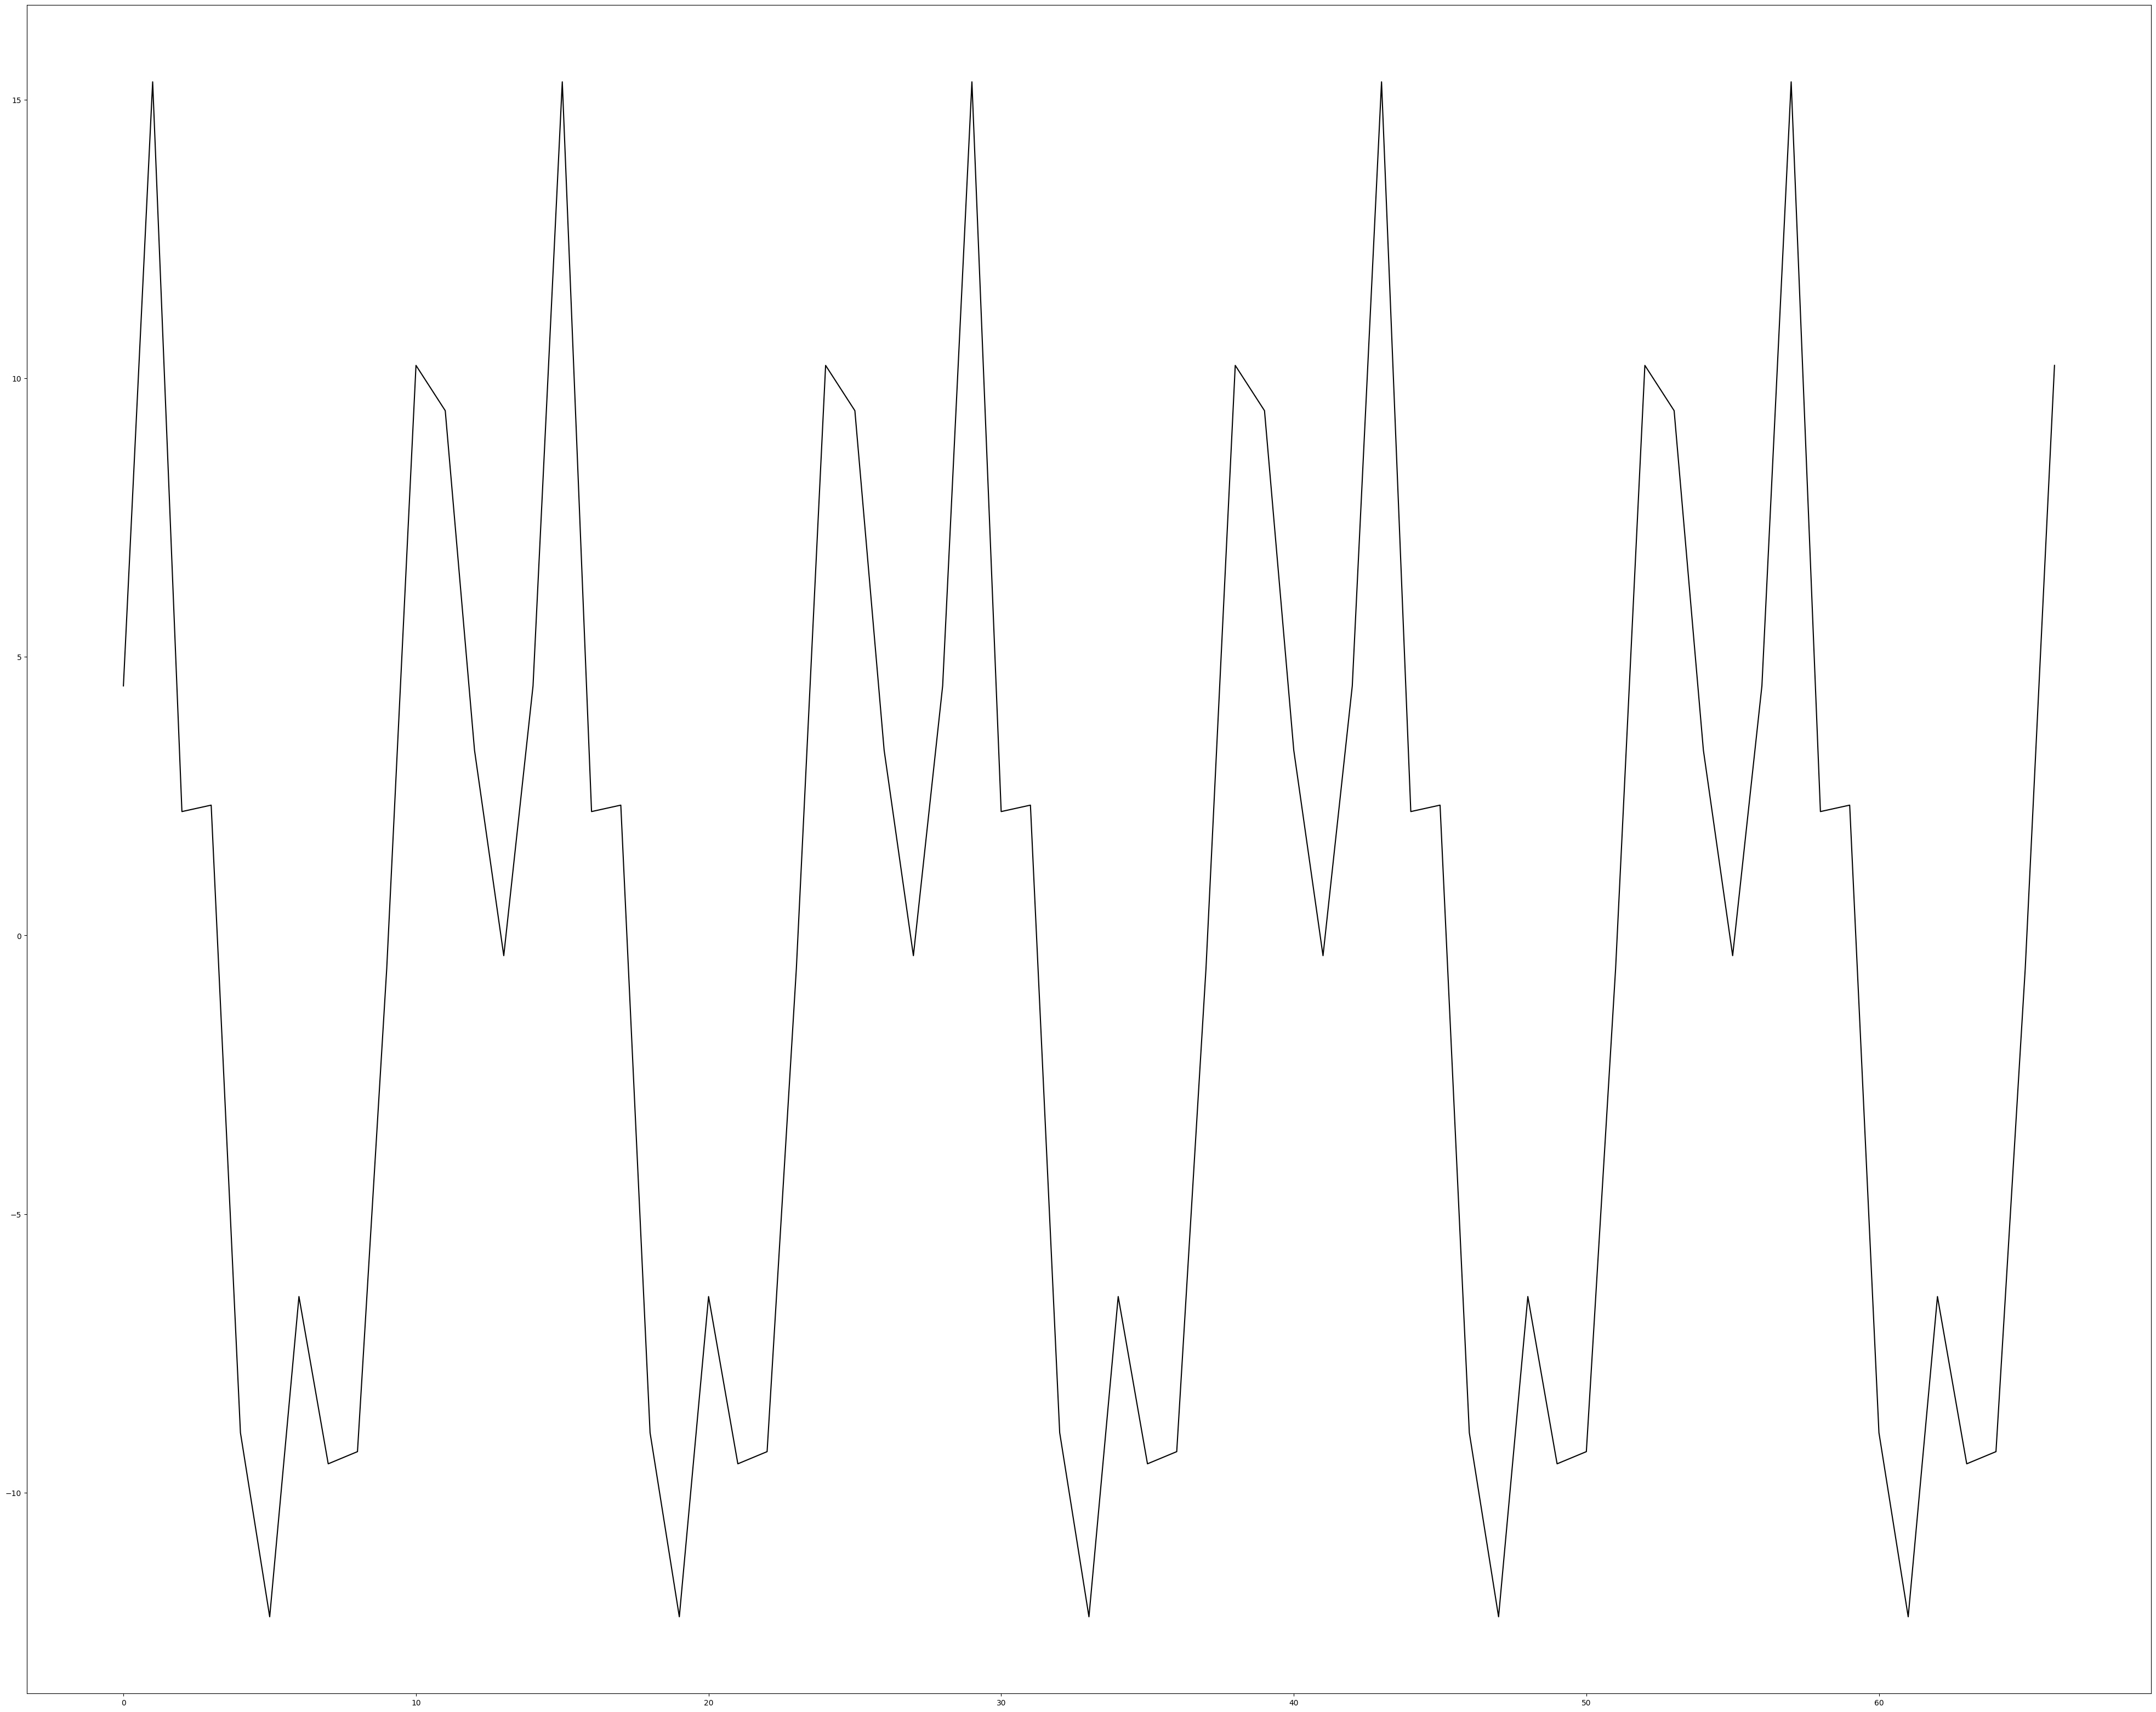

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(seasons[0], color='black')

In [39]:
seasons[0].shape, trends[0].shape

((67,), (67,))

In [40]:
trends_dropna = list()
seasons_cropped = list()

for trend in trends:
    trends_dropna.append(trend[~np.isnan(trend)])

for season in seasons:
    seasons_cropped.append(season[int(trend_period/2):-int(trend_period/2)])

trends_dropna = np.array(trends_dropna)
seasons_cropped = np.array(seasons_cropped)

In [41]:
seasons_cropped[0].shape

(53,)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = list(MinMaxScaler() for i in range(trends_dropna.shape[0]))
trends_scaled = list()

scaler_seasonal = list(MinMaxScaler() for i in range(seasons_cropped.shape[0]))
seasons_scaled = list()

for i in range(trends_dropna.shape[0]):
    trends_scaled.append(scaler[i].fit_transform(trends_dropna[i].reshape(-1,1)))

for i in range(seasons_cropped.shape[0]):
    seasons_scaled.append(scaler_seasonal[i].fit_transform(seasons_cropped[i].reshape(-1,1)))

trends_scaled = np.array(trends_scaled)
seasons_scaled = np.array(seasons_scaled)

In [43]:
trends_scaled[0].reshape(1,-1), seasons_scaled[0].reshape(1,-1)

(array([[0.94314779, 0.97864165, 1.        , 0.99865672, 0.98245225,
         0.96491308, 0.94234238, 0.91819221, 0.8884812 , 0.84907999,
         0.81445983, 0.78126832, 0.75045599, 0.73265503, 0.71953267,
         0.69134136, 0.66804779, 0.66897555, 0.67020499, 0.66377901,
         0.65379851, 0.63846209, 0.6321471 , 0.63775632, 0.63306916,
         0.62453437, 0.61642642, 0.59503673, 0.5756648 , 0.56671167,
         0.54481832, 0.50626518, 0.46718552, 0.42529412, 0.39334911,
         0.36644698, 0.33077953, 0.29907926, 0.27037855, 0.22953446,
         0.17752883, 0.12406045, 0.06840926, 0.0266801 , 0.00594502,
         0.        , 0.00927475, 0.02747703, 0.04399169, 0.07593671,
         0.13050082, 0.17773959, 0.21441728]]),
 array([[0.0996474 , 0.10757783, 0.42228351, 0.81526139, 0.78575966,
         0.56456956, 0.43070553, 0.60644681, 1.        , 0.52458064,
         0.52877232, 0.11992407, 0.        , 0.20861744, 0.0996474 ,
         0.10757783, 0.42228351, 0.81526139, 0.78575966

In [44]:
trends_scaled.shape

(3457, 53, 1)

In [45]:
X_input = list()
y_input = list()

for trend, season in zip(trends_scaled, seasons_scaled):
    X_input.append(np.hstack((trend[:trend.shape[0]-7], season[:season.shape[0]-7])))
    y_input.append(trend[trend.shape[0]-7:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [46]:
X_input.shape, y_input.shape

((3457, 46, 2), (3457, 7, 1))

In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = Sequential([
    #Bidirectional(LSTM(units), input_shape=(input_period, num_features)),
    LSTM(units=units, input_shape=(input_period, num_features)),
    #LSTM(units=units, return_sequences=True, input_shape=(input_period, num_features)),
    #Dropout(0.2),
    #LSTM(units=units, return_sequences=False),
    #Dropout(0.2),
    Dense(output_step)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define a ModelCheckpoint callback to save weights at the end of each epoch
checkpoint = ModelCheckpoint(filepath='model_weights_6/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)

# Adding early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [113]:
history = model.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150
44/44 [==============================] - 46s 1s/step - loss: 0.2245 - val_loss: 0.0790
Epoch 2/150
44/44 [==============================] - 42s 955ms/step - loss: 0.0614 - val_loss: 0.0570
Epoch 3/150
44/44 [==============================] - 40s 914ms/step - loss: 0.0401 - val_loss: 0.0274
Epoch 4/150
44/44 [==============================] - 44s 1s/step - loss: 0.0320 - val_loss: 0.0259
Epoch 5/150
44/44 [==============================] - 43s 973ms/step - loss: 0.0265 - val_loss: 0.0308
Epoch 6/150
44/44 [==============================] - 46s 1s/step - loss: 0.0246 - val_loss: 0.0235
Epoch 7/150
44/44 [==============================] - 43s 975ms/step - loss: 0.0229 - val_loss: 0.0196
Epoch 8/150
44/44 [==============================] - 41s 942ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 9/150
44/44 [==============================] - 40s 919ms/step - loss: 0.0190 - val_loss: 0.0286
Epoch 10/150
44/44 [==============================] - 50s 1s/step - loss: 0.0184 - val_loss

In [ ]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_6/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

In [48]:
best_epoch_backup = 41

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_6/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


# data testing:

In [49]:
#data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup = pd.read_csv('data-china-from2018-test/000001.SS_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [50]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [51]:
X_test.shape, y_test.shape

((1547, 60), (1547, 7))

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test = np.array([decompositions_test[i].trend for i in range(decompositions_test.shape[0])])
seasons_test = np.array([decompositions_test[i].seasonal for i in range(decompositions_test.shape[0])])

In [53]:
trends_test[0], trends_test[0].shape

(array([          nan,           nan,           nan,           nan,
                  nan,           nan,           nan, 3370.96757289,
        3369.65993827, 3367.15727016, 3364.13677979, 3361.92138672,
        3360.28474644, 3358.38915144, 3357.22536795, 3357.00147356,
        3357.56215123, 3359.32426235, 3361.47230748, 3363.23263114,
        3364.22084263, 3365.29323033, 3366.77983747, 3368.73490688,
        3371.38543701, 3374.24586705, 3377.82557896, 3381.96413749,
        3385.57334682, 3387.35130964, 3387.79441616, 3388.32552665,
        3388.41838728, 3387.9205671 , 3388.25653076, 3389.96774728,
        3392.72020612, 3396.09287807, 3399.7043457 , 3403.68870326,
        3406.98291888, 3407.96892439, 3407.16163853, 3406.269104  ,
        3405.97010149, 3406.45731027, 3408.66227504, 3409.67653111,
        3407.77982003, 3403.29060582, 3397.10675049, 3390.97332764,
        3383.63697161,           nan,           nan,           nan,
                  nan,           nan,           

In [54]:
trends_dropna_test = list()
seasons_cropped_test = list()

for trend in trends_test:
    trends_dropna_test.append(trend[~np.isnan(trend)])

for season in seasons_test:
    seasons_cropped_test.append(season[int(trend_period/2):-int(trend_period/2)])

trends_dropna_test = np.array(trends_dropna_test)
seasons_cropped_test = np.array(seasons_cropped_test)

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler_test = list(MinMaxScaler() for i in range(trends_dropna_test.shape[0]))
trends_scaled_test = list()

scaler_seasonal_test = list(MinMaxScaler() for i in range(seasons_cropped_test.shape[0]))
seasons_scaled_test = list()

for i in range(trends_dropna_test.shape[0]):
    trends_scaled_test.append(scaler_test[i].fit_transform(trends_dropna_test[i].reshape(-1,1)))

for i in range(seasons_cropped_test.shape[0]):
    seasons_scaled_test.append(scaler_seasonal_test[i].fit_transform(seasons_cropped_test[i].reshape(-1,1)))

trends_scaled_test = np.array(trends_scaled_test)
seasons_scaled_test = np.array(seasons_scaled_test)

In [56]:
X_input_test = list()
#y_input = list()

for trend, season in zip(trends_scaled_test, seasons_scaled_test):
    X_input_test.append(np.hstack((trend, season)))
    #y_input.append(trend[trend.shape[0]-7:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [57]:
# Prepare reference y_test
test_input = np.array([np.concatenate((X_test[i], y_test[i]), axis=0) for i in range(X_test.shape[0])])

decompose_test_input = np.array([seasonal_decompose(test_input[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test_input = np.array([decompose_test_input[i].trend for i in range(decompose_test_input.shape[0])])

trends_test_input_dropna = list()
for trend in trends_test_input:
    trends_test_input_dropna.append(trend[~np.isnan(trend)])

trends_test_input_dropna = np.array(trends_test_input_dropna)

y_input = list()
for trend in trends_test_input_dropna:
    y_input.append(trend[trend.shape[0]-7:])

y_input = np.array(y_input)

In [58]:
X_input_test.shape

(1547, 46, 2)

In [59]:
trend_predictions_test = list()

for j in range(X_input_test.shape[0]):
    #print(j+1)
    trend_predictions_test.append(
        scaler_test[j].inverse_transform(
            model.predict(X_input_test[j].reshape(trends_scaled_test[j].shape[1], input_period, num_features), verbose=0)
        )
    )

trend_predictions_test = np.array(trend_predictions_test)

In [29]:
trend_predictions_test.shape

(1547, 1, 7)

In [60]:
# Logistic transformation
def logistic_transform(r2):
    return round(1 / (1 + np.exp(-r2)),2)
        
def report_score(outputs):
    from sklearn.metrics import r2_score
    
    pred, y = outputs
    
    try:
        assert pred.shape[2] == output_step
        assert y.shape[1] == output_step

        _pred = pred.reshape(-1, output_step)
        _y = y.reshape(-1, output_step)
    
        res = list()
        for i in range(_pred.shape[0]):
            res.append(r2_score(_y[i], _pred[i]))

        res = np.array(res)
    
        return {
            'mean_score': np.mean(res),
            'max_score': res.max(),
            'min_score': res.min(),
            'logistic_score': logistic_transform(np.mean(res))
        }
    except:
        print("Array shapes don't match")

In [61]:
report_score((trend_predictions_test, y_input))

{'mean_score': -14.770033139687513,
 'max_score': 0.9862667705298853,
 'min_score': -1466.0234278899138,
 'logistic_score': 0.0}

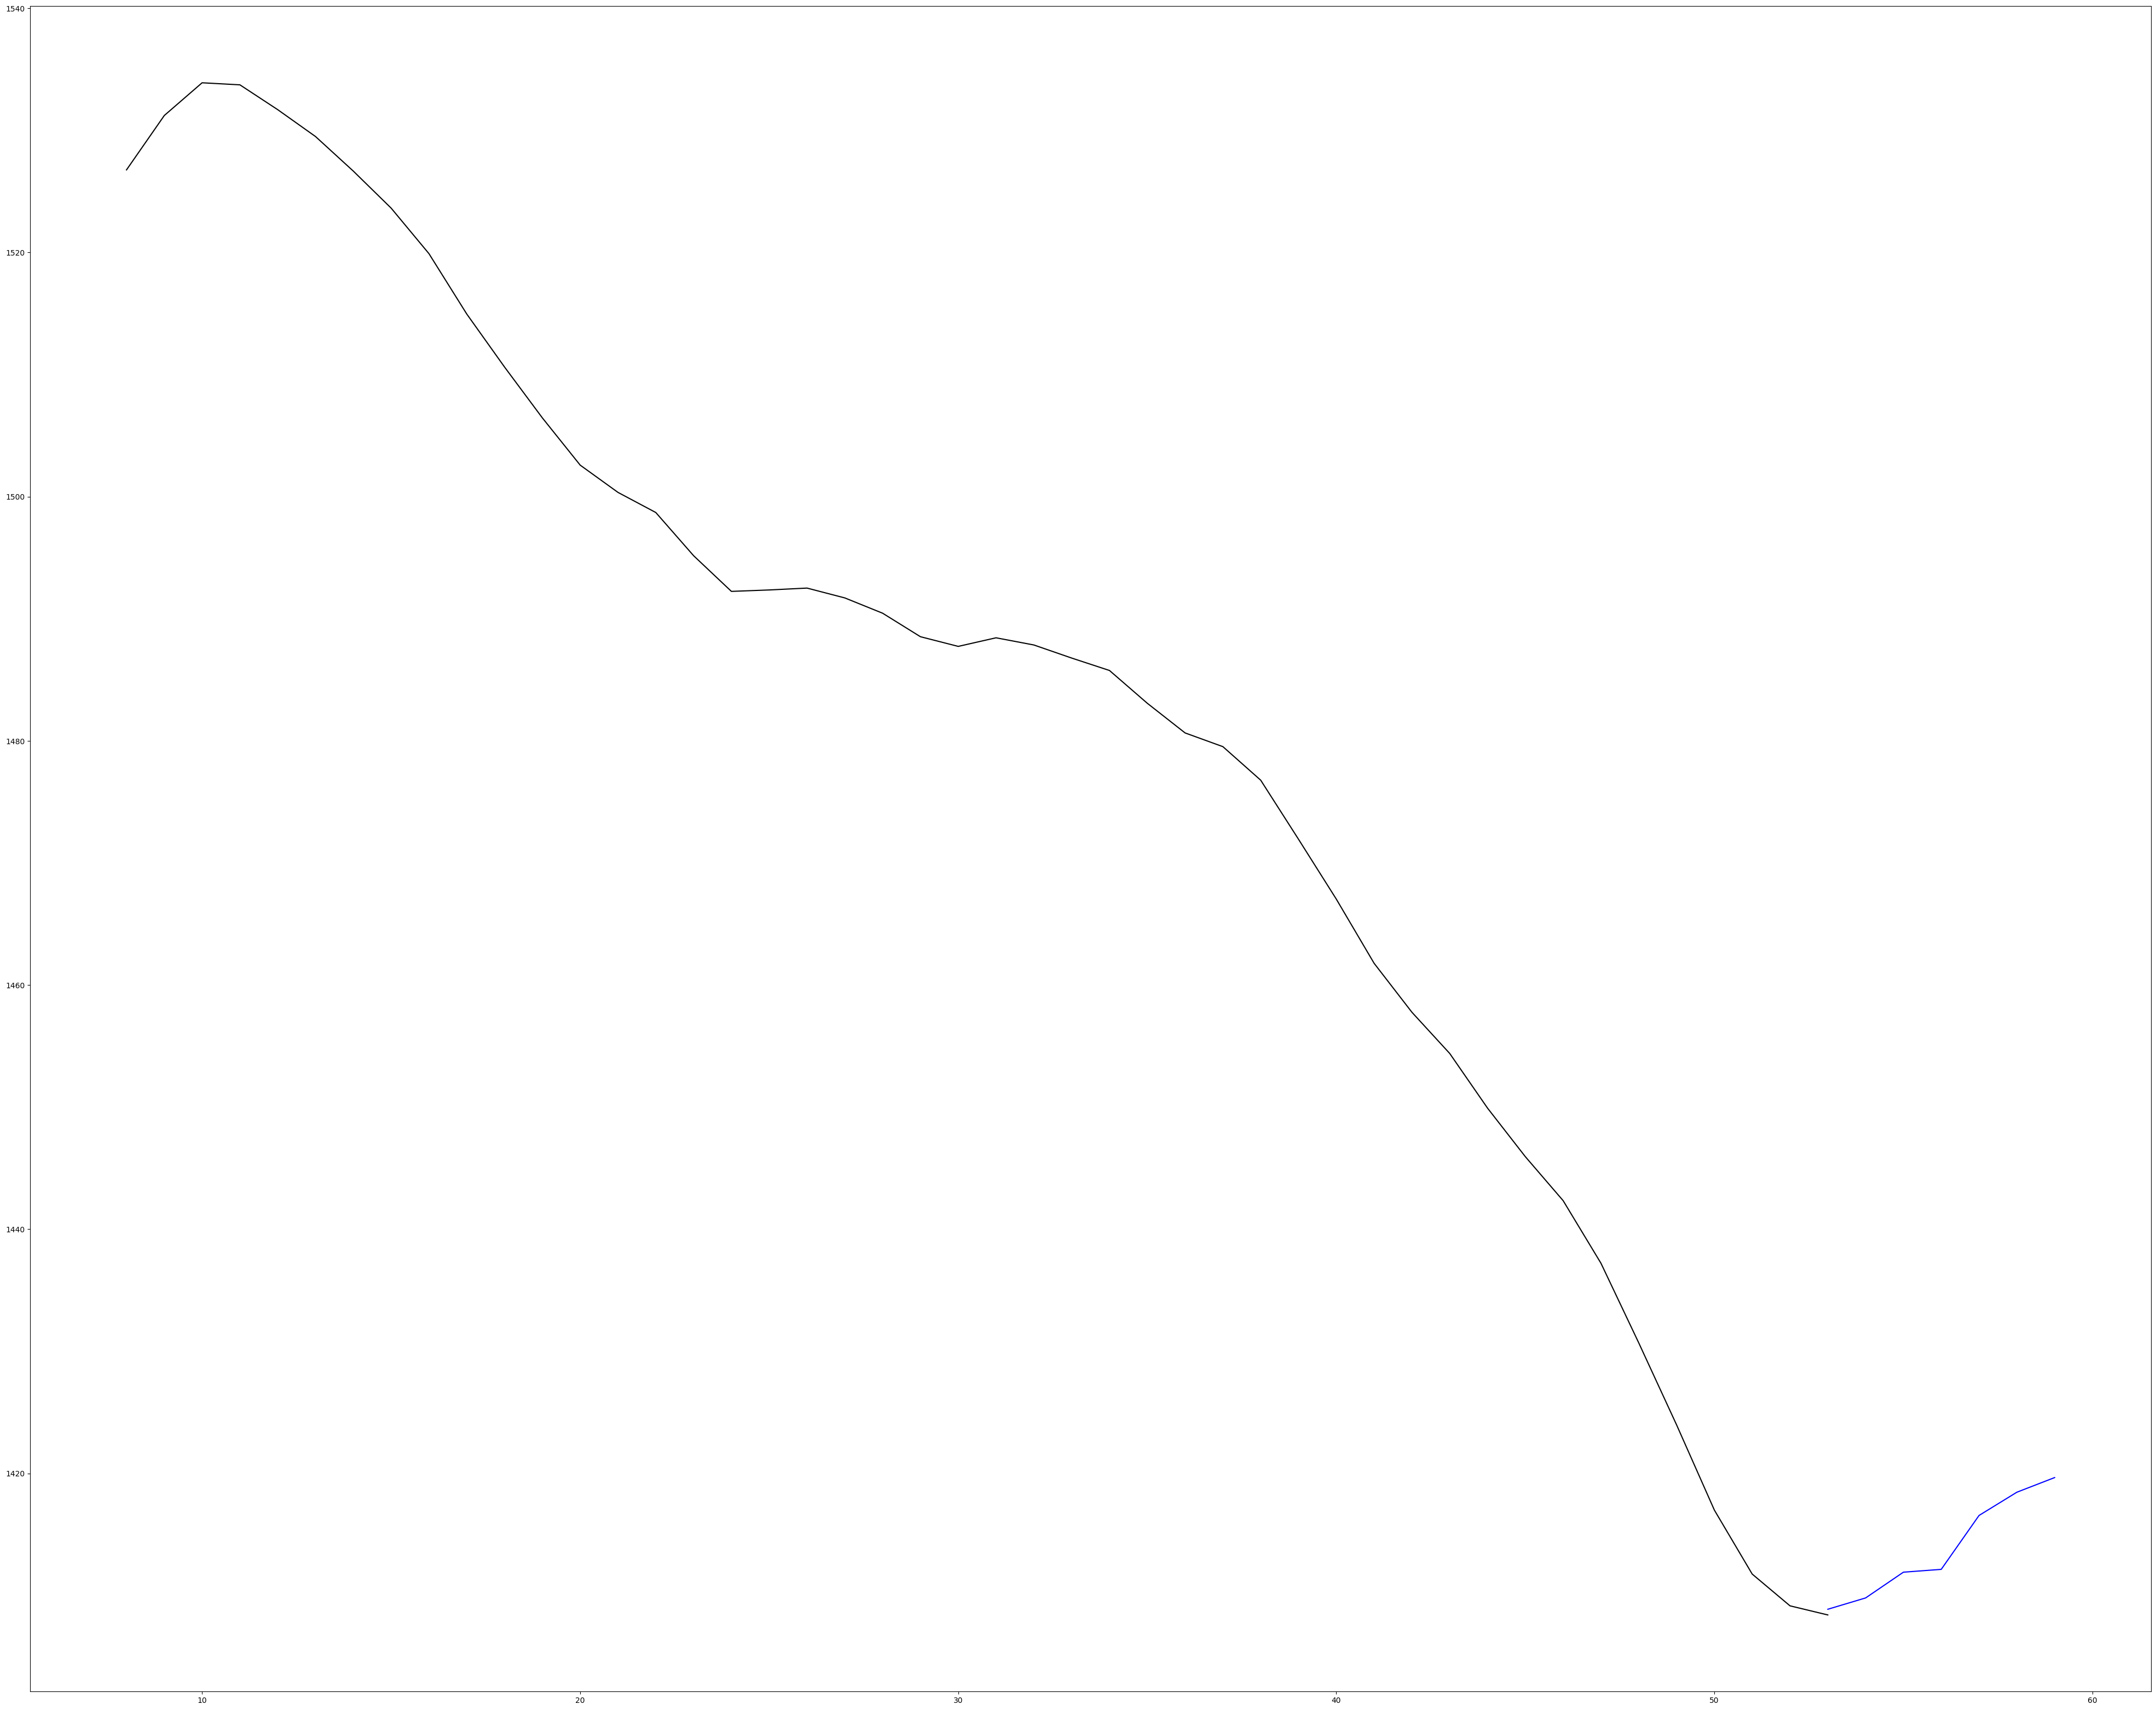

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(data_backup.index[53:60], trend_predictions_test[0][0], color='blue')
plt.plot(data_backup.index[8:54], trends_dropna_test[0], color='black')

In [139]:
trends_test_df = pd.DataFrame(trends_dropna_test, index=data_backup.index[output_step:-period])

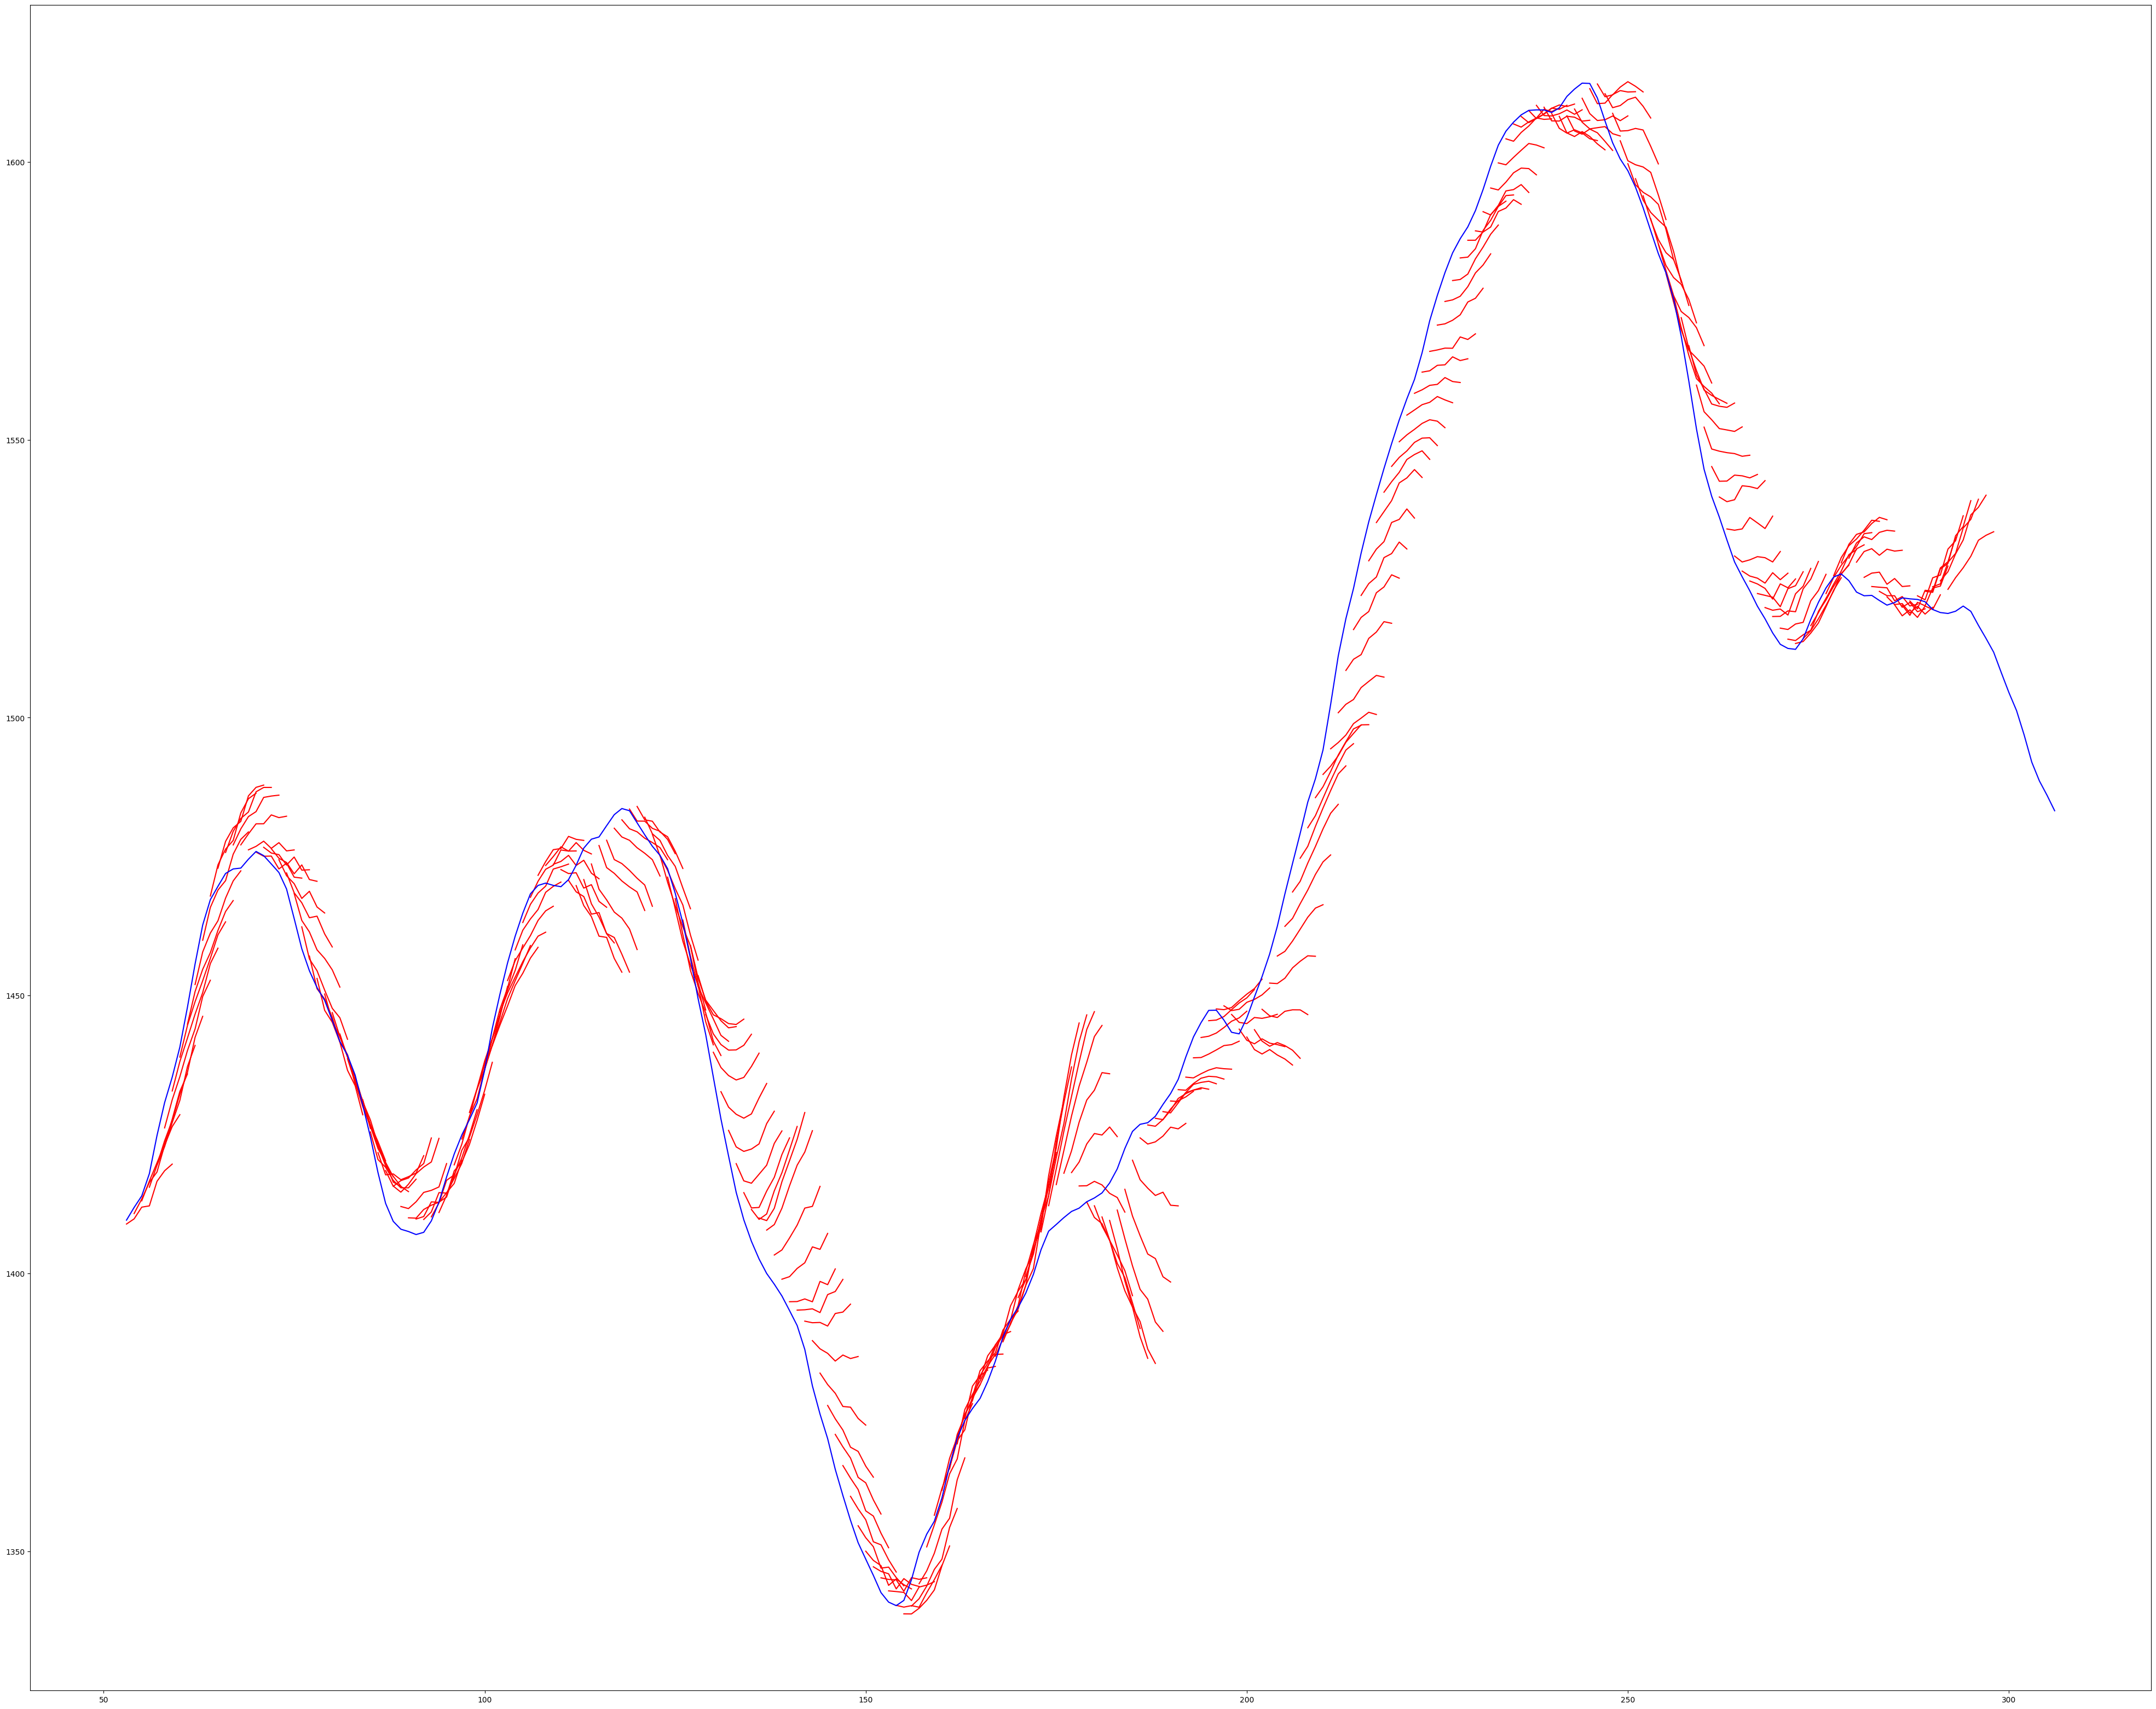

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for i in range(240):
    plt.plot(data_backup.index[i+(input_period+output_step):i+period], trend_predictions_test[i][0], color='red')

plt.plot(trends_test_df[0].iloc[46:300], color='blue')